#  InceptionResNetV2 : Images - Iteration #3(Without Data Augementation)

img_rows = 299 <br>
img_cols = 299 <br>
batch_size = 64 <br>
epochs = 40 <br>
Train set size = 67933 <br>
Valid set size = 16983 <br>

**<u>Results</u>**

Accuracy : 0.62 <br>
F1 score weighted : 0.61

**Import packages**

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import re
tqdm_notebook.pandas()
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import pickle
from joblib import dump, load

# Iteration #3 - InceptionResNetV2

***Read DataFrame from saved pickele file - image Train set***

In [3]:
path = 'D:/DataScienTest_WorkSpace/WS/'

In [4]:
#Load df of images already resized on 256 x 256 
#df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_19102021.pkl")

#Load df of images with org size 500 x 500
df_train_im = pd.read_pickle(path +"/saves/df_save/df_train_combined_ORG_im_size_02122021.pkl")

In [5]:
df_train_im.head()

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,image_1077757786_product_278535884.jpg


In [6]:
display(df_train_im.shape)

(84916, 6)

***Create Dataframe containing  product classes and their associated labels***

In [7]:
#Dictionary of prdtypecode and their corresponding categories
dict_prdtypecode = {"prdtypecode" : [50, 2705, 2522, 2582, 1560, 1281, 1920, 1280, 1140, 1300, 2060, 2583,
                                     60, 1320, 2280, 1302, 2220, 40, 2905, 2585, 1940, 1160, 1301, 10, 1180,
                                     2403, 2462],                 
            
                    "Label" : ["video games accessories", "books", "stationery", "kitchen and garden", 
                               "interior furniture and bedding", "board games", "interior accessories",
                               "toys for children","goodies", "remote controlled models", "decoration interior",
                               "piscine spa","games and consoles", "early childhood", "magazines", "kids toys",
                               "supplies for domestic animals", "imported video games", "online distribution of video games",
                               "gardening and DIY","Food","playing cards", "accessories children", "adult books",
                               "figurines_wargames", "children books",
                                "games"]
                   }
df_class = pd.DataFrame(data=dict_prdtypecode)
df_class

,prdtypecode,Label
0,50,video games accessories
1,2705,books
2,2522,stationery
3,2582,kitchen and garden
4,1560,interior furniture and bedding
5,1281,board games
6,1920,interior accessories
7,1280,toys for children
8,1140,goodies
9,1300,remote controlled models


In [8]:
# Crate DF containing prdtypecode , categories and corresponding class used by model
df_class = df_class.sort_values(by = 'prdtypecode', ascending = True)
df_class['target_prdtypecode'] = [i for i in range(27)]
df_class

,prdtypecode,Label,target_prdtypecode
23,10,adult books,0
17,40,imported video games,1
0,50,video games accessories,2
12,60,games and consoles,3
8,1140,goodies,4
21,1160,playing cards,5
24,1180,figurines_wargames,6
7,1280,toys for children,7
5,1281,board games,8
9,1300,remote controlled models,9


***Change the 27 product codes to 0 to 26***

In [9]:
df_train_im.replace({'prdtypecode':{10:0,
                                    40:1,
                                    50:2,
                                    60:3,
                                    1140:4,
                                    1160:5,
                                    1180:6,
                                    1280:7,
                                    1281:8,
                                    1300:9                                    
                                    }}, inplace = True)

df_train_im.replace({'prdtypecode':{1301:10,
                                    1302:11,
                                    1320:12,
                                    1560:13,
                                    1920:14,
                                    1940:15,
                                    2060:16,
                                    2220:17,
                                    2280:18,
                                    2403:19,
                                    2462:20,
                                    2522:21,
                                    2582:22,
                                    2583:23,
                                    2585:24,
                                    2705:25,
                                    2905:26
                                    }}, inplace = True)

In [10]:
display(df_train_im["prdtypecode"].unique())

array([ 0, 18,  2,  7, 25, 21, 22, 13,  8, 14, 19,  4, 23,  6,  9, 20,  5,
       16,  1,  3, 12, 11, 17, 26, 24, 15, 10], dtype=int64)

 ***Convert product code to string type***

In [11]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

In [12]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

{'0': 3116,
 '1': 2508,
 '10': 807,
 '11': 2491,
 '12': 3241,
 '13': 5073,
 '14': 4303,
 '15': 803,
 '16': 4993,
 '17': 824,
 '18': 4760,
 '19': 4774,
 '2': 1681,
 '20': 1421,
 '21': 4989,
 '22': 2589,
 '23': 10209,
 '24': 2496,
 '25': 2761,
 '26': 872,
 '3': 832,
 '4': 2671,
 '5': 3953,
 '6': 764,
 '7': 4870,
 '8': 2070,
 '9': 5045}

 ***Split Train Set***

In [13]:
# Split Train set 
#X_train_im, X_test_im = train_test_split(df_train_im, train_size=0.8, random_state=1234)

In [14]:
#display(X_train_im.shape)
#display(X_test_im.shape)

***Data Generator***

In [15]:
%%time
#Générateur de données
img_gen = ImageDataGenerator(rescale = 1/255, 
                             validation_split = 0.2)

Wall time: 1.03 ms


In [18]:
img_rows = 299
img_cols = 299
batch_size = 64
epochs = 40

# Directory of images already resized on 256 x 256 
#images_dir_train = './data/images/all/image_train_resized/'
#images_dir_train = 'E:/WorkSpace_DataScience_E/Rakuten_Projet_Local/My_WS/data/images/all/image_train_resized/'

# Directory of images org resize 500 x 500
images_dir_train = path +'/data/images/all/image_train/'
#images_dir_train = 'E:/WorkSpace_DataScience_E/Rakuten_Projet_Local/My_WS/data/images/all/image_train/'

In [19]:
%%time

#Itérateur 
train_generator = img_gen.flow_from_dataframe(dataframe = df_train_im,
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True, # défault
                                              subset = 'training'
                                             )

Found 67933 validated image filenames belonging to 27 classes.
Wall time: 6.35 s


In [20]:
%%time
# validation_split the validation batches ca be retrieved by specifying the subset as validation.
valid_generator = img_gen.flow_from_dataframe(dataframe = df_train_im, 
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False,
                                              subset  = 'validation'
                                             )

Found 16983 validated image filenames belonging to 27 classes.
Wall time: 5.44 s


In [22]:
valid_generator.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '3': 20,
 '4': 21,
 '5': 22,
 '6': 23,
 '7': 24,
 '8': 25,
 '9': 26}

 ***InceptionResNetV2 Implementation***

In [34]:
%%time
# Chargement du modèle inceptionResNetV2
inceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top = False, input_shape=(img_rows,img_rows,3))

# Bloquage du blackbone
for layer in inceptionResNetV2.layers:
    layer.trainable = False
    
model = Sequential()
model.add(inceptionResNetV2)
# Ajout des couche de classification
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024,activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 512, activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 27, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)               

 ***Compilation***

In [35]:
%%time
# Compilation
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation


Wall time: 13.2 ms


***Callbacks***

In [40]:
%%time
path = './saves/InceptionResNetV2/Iteration_3/'
file_name = 'checkpoint_InceptionResNetV2_16122021_299x299_40Epochs.h5'

#Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :
checkpoint = ModelCheckpoint(filepath = path + file_name , 
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', #(permet de préciser si la métrique doit croître ou décroitre : ici on choisit 'min'
                                           #car la métrique est une perte à minimiser)
                             save_freq='epoch')
#Arrêter l'entraînement si le modèle n'évolue plus (très pratique pour ne pas gérer le
#nombre d'epoch) :
early = EarlyStopping(monitor='val_loss',
                      min_delta = 0,
                      patience = 10, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,
                      verbose = 1,
                      mode = 'min')

Wall time: 0 ns


 ***Fit - train_generator***

In [41]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  1061
step_size_Valid  :  265


In [42]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    callbacks=[checkpoint, early]                    
                    )

Epoch 1/40
1061/1061 [==============================] - 417s 392ms/step - loss: 1.4548 - accuracy: 0.5626 - val_loss: 1.4119 - val_accuracy: 0.5757

Epoch 00001: val_accuracy improved from -inf to 0.57571, saving model to ./saves/InceptionResNetV2/Iteration_3\checkpoint_InceptionResNetV2_16122021_299x299_40Epochs.h5
Epoch 2/40
1061/1061 [==============================] - 412s 389ms/step - loss: 1.3852 - accuracy: 0.5809 - val_loss: 1.3812 - val_accuracy: 0.5877

Epoch 00002: val_accuracy improved from 0.57571 to 0.58768, saving model to ./saves/InceptionResNetV2/Iteration_3\checkpoint_InceptionResNetV2_16122021_299x299_40Epochs.h5
Epoch 3/40
1061/1061 [==============================] - 412s 388ms/step - loss: 1.3263 - accuracy: 0.5958 - val_loss: 1.3473 - val_accuracy: 0.5931

Epoch 00003: val_accuracy improved from 0.58768 to 0.59310, saving model to ./saves/InceptionResNetV2/Iteration_3\checkpoint_InceptionResNetV2_16122021_299x299_40Epochs.h5
Epoch 4/40
1061/1061 [==================

***Save History results***

In [43]:
# Save History results
path = './saves/InceptionResNetV2/Iteration_3/'
filename = 'history_InceptionResNetV2_all_train_16122021_299x299_40Epochs'

In [44]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# history to json:  
hist_json_file = path + filename + '.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# history to csv: 
hist_csv_file = path + filename +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# history to pickle file
hist_df.to_pickle(path + filename +'.pkl')

***Display Model loss , accuracy per epoch***

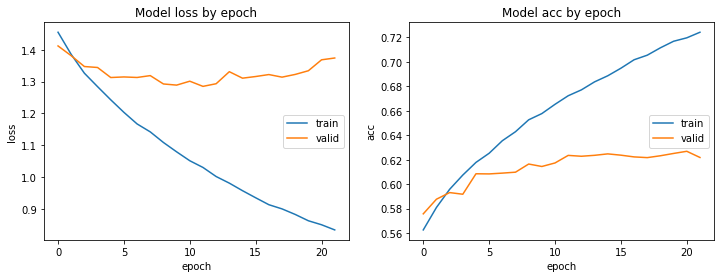

In [45]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

 ***Prediction - test_generator***

In [36]:
%%time
#Prediction - Valid set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from test generator
y_true = valid_generator.classes

Wall time: 1min 36s


 ***Evaluation - test_generator***

In [37]:
%%time
#Get the accuracy score
valid_score = model.evaluate(valid_generator)
print("[INFO] Model metrics names:", model.metrics_names)
print("[INFO] Accuracy: {:.2f}%".format(valid_score[1] * 100)) 
print("[INFO] Loss: ",valid_score[0])

266/266 [==============================] - 85s 309ms/step - loss: 1.2857 - accuracy: 0.6234
[INFO] Model metrics names: ['loss', 'accuracy']
[INFO] Accuracy: 62.34%
[INFO] Loss:  1.2856836318969727
Wall time: 1min 25s


In [38]:
f1_macro = f1_score(y_true, y_pred_class, average='macro')
print("[INFO] f1 score macro average: ",f1_macro)

f1_micro = f1_score(y_true, y_pred_class, average='micro')
print("[INFO] f1 score micro average: ",f1_micro)

f1_weighted = f1_score(y_true, y_pred_class, average='weighted')
print("[INFO] f1 score weighted average: ",f1_weighted)

[INFO] f1 score macro average:  0.5731678525509076
[INFO] f1 score micro average:  0.6233880939763292
[INFO] f1 score weighted average:  0.6144108943506252


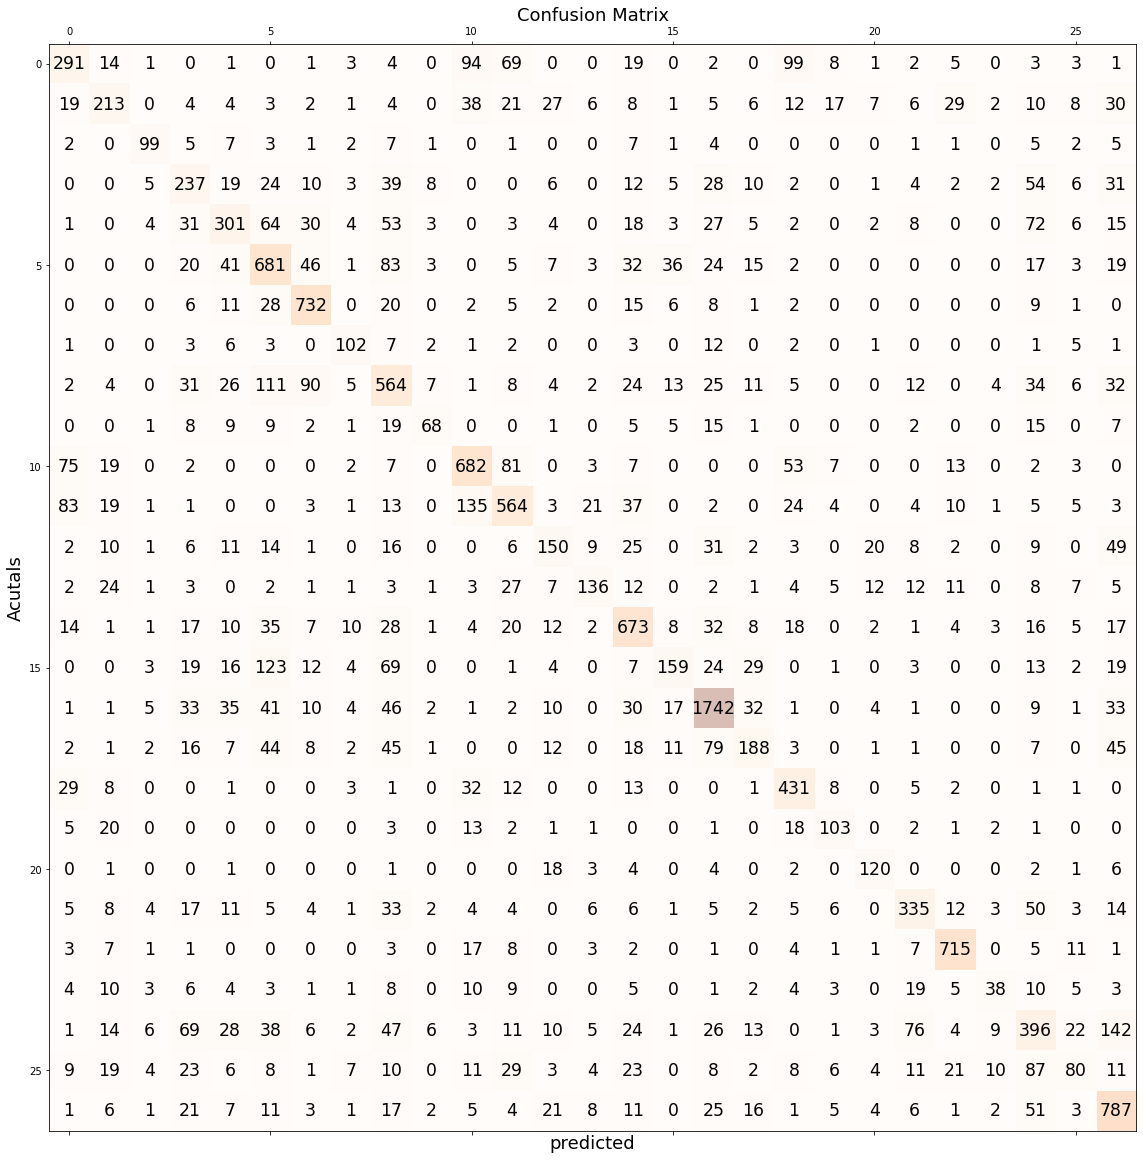

In [57]:
#Confusion matrix
matrix = confusion_matrix(y_true, y_pred_class)
fig , ax = plt.subplots(figsize = (24,20))
ax.matshow(matrix, cmap = plt.cm.Oranges , alpha = 0.3)
for i in range(matrix.shape[0]):
    for j in range (matrix.shape[1]):
        ax.text (x = j , y= i, s= matrix[i,j], va = 'center', ha = 'center', size = 'xx-large')
        
plt.xlabel('predicted', fontsize = 18)
plt.ylabel('Acutals', fontsize = 18)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()
#print(matrix)

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

In [47]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),]

In [146]:
#target_names = [i for i in range(27)]
#target_names
target_names = [10,40,1281,1300,1302,1320,1560,1920 ,1940,2060,2220,2280,1301,2403,2522,2582,2583,2585,2705,2905,
                     50,2462,60,1140,1160,1180,1280]

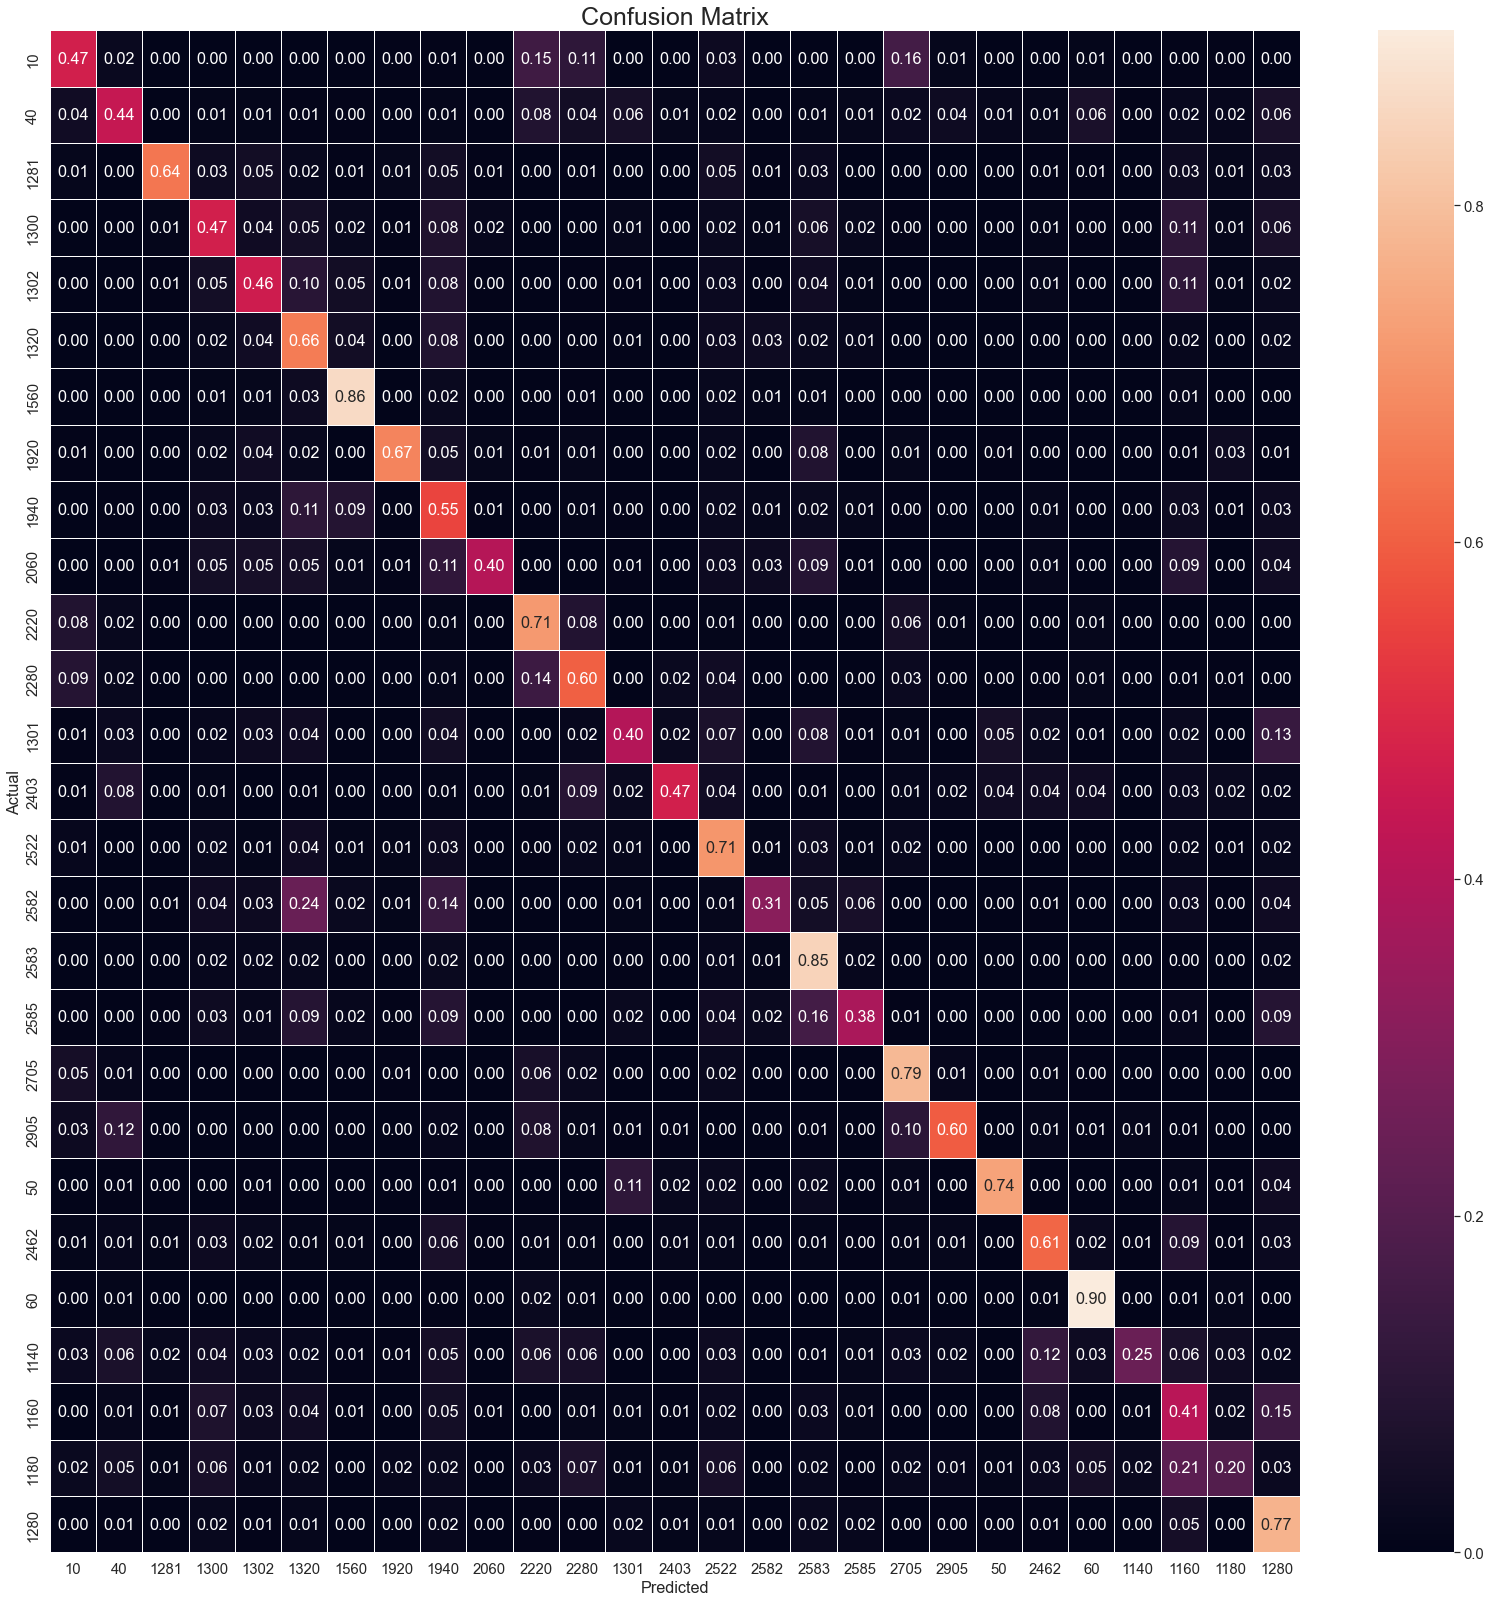

In [178]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.35) # Adjust to fit
fig, ax = plt.subplots(figsize=(28,28))


title_font = {'size':'25'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

sns.heatmap(cmn, annot=True, 
            fmt='.2f',
            xticklabels=target_names,
            yticklabels=target_names,
            linewidths=.8)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [179]:
col_class_num = [10,40,1281,1300,1302,1320,1560,1920 ,1940,2060,2220,2280,1301,2403,2522,2582,2583,2585,2705,2905,
                     50,2462,60,1140,1160,1180,1280]
col_class_label = ['adult books','imported video games','board games',
                    'remote controlled models','toys, outdoor playing, clothes',
                    'early childhood','interior furniture and bedding',
                    'interior accessories','Food','decoration interior',
                    'supplies for domestic animals','magazines',
                    'accessories children','children books and magazines',
                    'stationery','furniture kitchen and garden',
                    'piscine spa','gardening and DIY','books',
                    'online distribution of video games',
                    'video games accessories','games',
                    'games and consoles','figurines and Toy Pop',
                    'playing cards','figurines, masks and role playing games',
                    'toys for children']

In [182]:
import pandas as pd
df_matrix = pd.DataFrame(matrix)
#df_matrix
df_matrix.columns = col_class_num
df_matrix.index = col_class_num
df_matrix_percentage = df_matrix.div(df_matrix.sum(axis=1), axis=0).round(2).applymap(lambda x: f'{x * 100:.2f}%')
df_matrix_percentage
#df_matrix



,10,40,1281,1300,1302,1320,1560,1920,1940,2060,...,2585,2705,2905,50,2462,60,1140,1160,1180,1280
10,47.00%,2.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.00%,0.00%,...,0.00%,16.00%,1.00%,0.00%,0.00%,1.00%,0.00%,0.00%,0.00%,0.00%
40,4.00%,44.00%,0.00%,1.00%,1.00%,1.00%,0.00%,0.00%,1.00%,0.00%,...,1.00%,2.00%,4.00%,1.00%,1.00%,6.00%,0.00%,2.00%,2.00%,6.00%
1281,1.00%,0.00%,64.00%,3.00%,5.00%,2.00%,1.00%,1.00%,5.00%,1.00%,...,0.00%,0.00%,0.00%,0.00%,1.00%,1.00%,0.00%,3.00%,1.00%,3.00%
1300,0.00%,0.00%,1.00%,47.00%,4.00%,5.00%,2.00%,1.00%,8.00%,2.00%,...,2.00%,0.00%,0.00%,0.00%,1.00%,0.00%,0.00%,11.00%,1.00%,6.00%
1302,0.00%,0.00%,1.00%,5.00%,46.00%,10.00%,5.00%,1.00%,8.00%,0.00%,...,1.00%,0.00%,0.00%,0.00%,1.00%,0.00%,0.00%,11.00%,1.00%,2.00%
1320,0.00%,0.00%,0.00%,2.00%,4.00%,66.00%,4.00%,0.00%,8.00%,0.00%,...,1.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,2.00%,0.00%,2.00%
1560,0.00%,0.00%,0.00%,1.00%,1.00%,3.00%,86.00%,0.00%,2.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.00%,0.00%,0.00%
1920,1.00%,0.00%,0.00%,2.00%,4.00%,2.00%,0.00%,67.00%,5.00%,1.00%,...,0.00%,1.00%,0.00%,1.00%,0.00%,0.00%,0.00%,1.00%,3.00%,1.00%
1940,0.00%,0.00%,0.00%,3.00%,3.00%,11.00%,9.00%,0.00%,55.00%,1.00%,...,1.00%,0.00%,0.00%,0.00%,1.00%,0.00%,0.00%,3.00%,1.00%,3.00%
2060,0.00%,0.00%,1.00%,5.00%,5.00%,5.00%,1.00%,1.00%,11.00%,40.00%,...,1.00%,0.00%,0.00%,0.00%,1.00%,0.00%,0.00%,9.00%,0.00%,4.00%


In [185]:
path_rep = 'D:/DataScienTest_WorkSpace/Rapport/'

In [186]:

df_matrix.to_pickle(path_rep + 'InceptionResNetV2_STep_1_confusion_matrix_not_normalized.pkl')
df_matrix.to_csv(path_rep + 'InceptionResNetV2_STep_1_confusion_matrix_not_normalized.csv')

df_matrix_percentage.to_pickle(path_rep + 'InceptionResNetV2_STep_1_confusion_matrix_normalized.pkl')
df_matrix_percentage.to_csv(path_rep + 'InceptionResNetV2_STep_1_confusion_matrix_normalized.csv')


In [145]:
#df_matrix.iloc[(0)]
df_matrix.loc[df_matrix[40] > 14]

,10,40,1281,1300,1302,1320,1560,1920,1940,2060,...,2585,2705,2905,50,2462,60,1140,1160,1180,1280
40,19,213,0,4,4,3,2,1,4,0,...,6,12,17,7,6,29,2,10,8,30
2220,75,19,0,2,0,0,0,2,7,0,...,0,53,7,0,0,13,0,2,3,0
2280,83,19,1,1,0,0,3,1,13,0,...,0,24,4,0,4,10,1,5,5,3
2403,2,24,1,3,0,2,1,1,3,1,...,1,4,5,12,12,11,0,8,7,5
2905,5,20,0,0,0,0,0,0,3,0,...,0,18,103,0,2,1,2,1,0,0
1180,9,19,4,23,6,8,1,7,10,0,...,2,8,6,4,11,21,10,87,80,11


In [138]:
df_matrix.loc[(1280)]

10        1
40        6
1281      1
1300     21
1302      7
1320     11
1560      3
1920      1
1940     17
2060      2
2220      5
2280      4
1301     21
2403      8
2522     11
2582      0
2583     25
2585     16
2705      1
2905      5
50        4
2462      6
60        1
1140      2
1160     51
1180      3
1280    787
Name: 1280, dtype: int64

In [126]:
df_matrix.columns[df_matrix.iloc[(10)]>0]

Int64Index([10, 40, 1300, 1920, 1940, 2220, 2280, 2403, 2522, 2705, 2905, 60,
            1160, 1180],
           dtype='int64')

In [123]:
df_matrix[df_matrix.columns[df_matrix.iloc[(1281)]>2]]

IndexError: single positional indexer is out-of-bounds

In [115]:
#df_matrix.loc[:,[(df_matrix[col] > 0.1).any() for col in df_matrix.columns]]
#df_matrix[(df_matrix[col_class_num] > 0)]
#df_matrix[(df_matrix > 0).any(axis=1)]
#filtr = (df_matrix == 0).any()
#sub_df = df_matrix.loc[: , filtr]
#sub_df
df_filter = df_matrix[(df_matrix > 0).all(axis=0)]
df_filter

,10,40,1281,1300,1302,1320,1560,1920,1940,2060,...,2585,2705,2905,50,2462,60,1140,1160,1180,1280
1940,2,4,0,31,26,111,90,5,564,7,...,11,5,0,0,12,0,4,34,6,32
1160,1,14,6,69,28,38,6,2,47,6,...,13,0,1,3,76,4,9,396,22,142


In [58]:
print(metrics.classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.53      0.47      0.50       621
           1       0.53      0.44      0.48       483
           2       0.69      0.64      0.67       154
           3       0.41      0.47      0.44       508
           4       0.54      0.46      0.49       656
           5       0.54      0.66      0.60      1038
           6       0.75      0.86      0.80       848
           7       0.63      0.67      0.65       152
           8       0.49      0.55      0.52      1021
           9       0.64      0.40      0.49       168
          10       0.65      0.71      0.68       956
          11       0.63      0.60      0.62       939
          12       0.50      0.40      0.44       375
          13       0.64      0.47      0.54       290
          14       0.65      0.71      0.68       949
          15       0.60      0.31      0.41       508
          16       0.82      0.85      0.83      2061
          17       0.54    

 ***Predict input image using trained model***

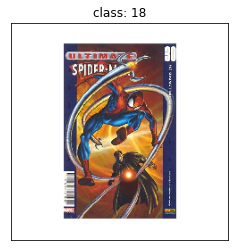

In [52]:
# Predict With Pre Trained

# Load an image
im_id = 127
img_path ='./data/images/all/image_train/'+ df_train_im['imagePath'][im_id]

img = image.load_img(img_path,target_size=(244, 244))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][im_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [53]:
im = cv2.resize(cv2.imread(img_path), (299, 299))
im = np.expand_dims(im, axis=0)

In [54]:
out = model.predict(im)
print("------------------Predicted Class and Label ------------------------------")
print("target class(used by model) :", np.argmax(out))
print("\n"  ,df_class[df_class['target_prdtypecode'] == np.argmax(out)][['prdtypecode', 'Label']].to_string(index=False)) 

prd_code = df_train_im['prdtypecode'][im_id]

print("\n\n------------------Real Class and Label ------------------------------")
print("target class(used by model): " ,  df_class[df_class['target_prdtypecode'] == int(prd_code)]['target_prdtypecode'].to_string(index=False))
print("\n"  ,df_class[df_class['target_prdtypecode'] == int(prd_code)][['prdtypecode', 'Label']].to_string(index=False)) 


 


------------------Predicted Class and Label ------------------------------
target class(used by model) : 10

  prdtypecode                Label
        1301 accessories children


------------------Real Class and Label ------------------------------
target class(used by model):  18

  prdtypecode     Label
        2280 magazines


 ***Save InceptionResNetV2 Model***

In [55]:
#Enregistrement du modèle
model.save("./saves/InceptionResNetV2/Iteration_3/Model_InceptionResNetV2_All_train_data_16122021_299x299_40Epochs.hdf5")
#The SavedModel and HDF5 file contains:
#the model's configuration (topology)
#the model's weights
#the model's optimizer's state (if any)

 ***Load InceptionResNetV2 Model***

In [33]:
path_mod = 'D:/Iteration_#3_Results/test_mod/'

In [34]:
f_mod_name = 'Model_InceptionResNetV2_All_train_data_16122021_299x299_40Epochs.hdf5'

In [35]:
#Rechargement du modèle :
model = load_model(path_mod + f_mod_name)

C:\Users\MME\anaconda3\envs\datascientestEnv\lib\site-packages\keras\layers\core\lambda_layer.py:297: UserWarning: tensorflow.python.keras.applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
